<a href="https://colab.research.google.com/github/Arrancara/gsoc_/blob/main/GSOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Abstract

The notebook is an attempt to formalise and show the process that is taken to build a model that can be used for classification of Dark Matter substructures.The candidate substructures obtained from strong lensing are none, subhalo and vortex.  These images have been simulated by producing imafges of diffrent fractions of halo mass for each class.  The model was trained using a 90/10 training and validation split.  Various models were tested and the final model was selected based on the results of a smaller training set. 
Average AUC score of 0.97397 is achieved using a model architecture inspired from EfficentNetB3.

Reference: https://arxiv.org/pdf/1909.07346.pdf, \\
          *Deep Learning of the Morphology of Dark Matter Substructures* \\
          Alexander S et al. Published: April, 2020:
          Publisher: American Astronomical Society
          \\
          \\
          \\
          \\
          

Loading file in from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab.patches import cv2_imshow
import cv2
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image
import os
import shutil
from cv2 import imwrite
from PIL import Image

plt.rcParams["figure.figsize"] = (20, 12)

Mounted at /content/drive


Due to time constraints, I am unable to fully develop the notebook as I would wish to or have learnt to do so in Computational Physics classes.  Ideally, I would like to seperate the notebook into sections, containing the physical theory including references and introduction to the experiment.  I believe that a notebook should read like a lab report and strive to maintain this standard. In the intrest of time the notebook has not been properly formatted.
\\
\\

For ease of usage of the Keras inbuilt image data generator, I am converting the numpy arrays and saving them as png files, as it preserves the image quality. 

Testing the procedure to ensure that the process is adding to noise of the images.

In [ ]:
import imageio
y = np.load("/content/drive/MyDrive/dataset/train/no/1.npy")
y = np.squeeze(y, 0)
y = np.array(y*255.0, dtype=np.uint8)
y = Image.fromarray(y)

y = y.convert("L")
y.save("test.png")

255 0
15.5848
(150, 150)


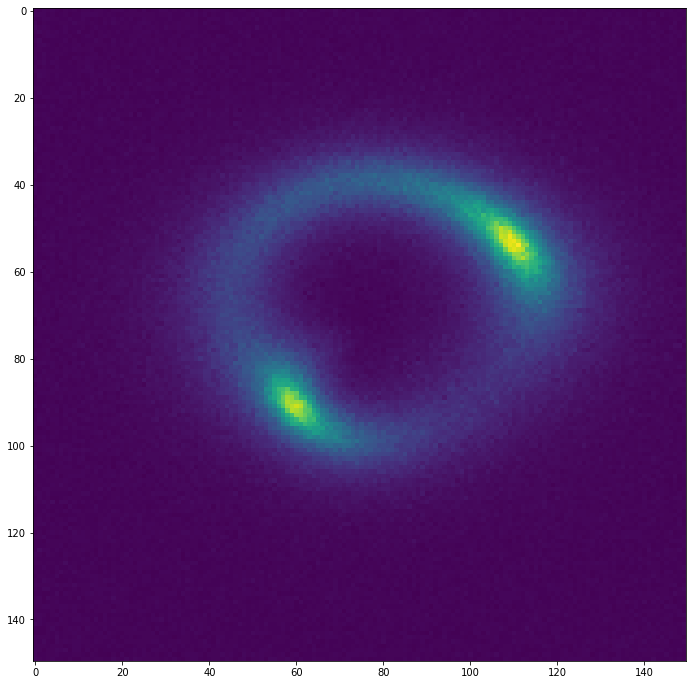

In [ ]:
img = Image.open("test.png")
#plt.hist(img.histogram());
#img = np.array(img, dtype=np.float64)
plt.imshow(img, cmap="viridis")
print(np.amax(img), np.amin(img))
print(np.mean(img))
#print(np.mean(y- np.array(img)))
print(np.shape(img))

###Data Loading and Augmentation.

Ensuring that there are the correct number of datapoints within the directories.

In [ ]:
#Define the training and validation base directories
import os
train_dir = "/content/drive/MyDrive/dataset/train/"
validation_dir = "/content/drive/MyDrive/dataset/val/"

#Setting up directory with the 3 classes.
train_no_dir = os.path.join("/content/drive/MyDrive/dataset/train/no")
train_sphere_dir = os.path.join("/content/drive/MyDrive/dataset/train/sphere")
train_vort_dir = os.path.join("/content/drive/MyDrive/dataset/train/vort")

#validation directories.
val_no_dir = os.path.join(validation_dir, "no")
val_sphere_dir = os.path.join(validation_dir, "sphere")
val_vort_dir = os.path.join(validation_dir, "vort")


print(f"There are {len(os.listdir(val_no_dir))} images of no for validation.\n")
print(f"There are {len(os.listdir(val_sphere_dir))} images of sphere for validation.\n")
print(f"There are {len(os.listdir(val_vort_dir))} images of vort for validation.\n")
print(f"There are {len(os.listdir(train_no_dir))} images of no for training.\n")
print(f"There are {len(os.listdir(train_sphere_dir))} images of sphere for training.\n")
print(f"There are {len(os.listdir(train_vort_dir))} images of vort for training.\n")


There are 2504 images of no for validation.

There are 2510 images of sphere for validation.

There are 2547 images of vort for validation.

There are 10000 images of no for training.

There are 10000 images of sphere for training.

There are 10000 images of vort for training.



The training data have been loaded correctly, the extra "1" is due to subfolders being present in the directory, there are duplicates within the validation set which will be removed manually (by searching withint he google drive for names, duplicates can skew the models validation accuracy positvely or negatively so it is very important to remove them.

\\

In [ ]:
import fnmatch

print(len(fnmatch.filter(os.listdir(train_sphere_dir), '*.png')))

10000


### Data Preprocessing
\\


Converting all npy files to png for easier usage by ImageDataGenerator. This also means that the footprint of the files is alot smaller!

In [ ]:
def convertor(src: str) -> int:
  """
  Loads the numpy arrays one by one and converts them into a file format, PNG
  and stores them into a desired directory.
  """
  for files in os.listdir(src):

    src_2 = os.path.join(src, "png")
    temp = files[0:-3] + "png"
    try:
      file_temp = np.load(os.path.join(src, files),allow_pickle=True)
      file_temp = np.squeeze(file_temp*255.0, 0)
      file_temp = Image.fromarray(file_temp)
      file_temp = file_temp.convert("L")
      file_temp.save(os.path.join(src_2, temp))
    except:
      pass
  return 1
      

In [ ]:
convertor(train_no_dir)
convertor(train_vort_dir)
convertor(train_sphere_dir)
convertor(val_no_dir)
convertor(val_sphere_dir)
convertor(val_vort_dir)

In [ ]:
from os import listdir
import os
def corrupt_checker(file_dir: str):
  """
  Checks if files were loaded correctly, and if they arent displays the name 
  and number of corrput files.
  """
  corrupt_file = 0
  bad_files = []
  num_files=0
  for filename in listdir(file_dir):
    if filename.endswith('.png'):
      try:
        img = Image.open(file_dir+"/"+filename) # open the image file
        img.verify() # verify that it is, in fact an image
        num_files +=1
      except (IOError, SyntaxError) as e:
        corrupt_file+=1
        os.remove(file_dir+"/"+filename)
        bad_files.append(filename)
        print('Bad file:', filename) # print out the names of corrupt files
  return corrupt_file, bad_files, num_files


I wanted to check to ensure that the validation and the training generator were yielding "reasonable" images, and it appears they are.

In [ ]:
#print(corrupt_checker(train_no_dir))
#print(corrupt_checker(train_vort_dir))
print(corrupt_checker(train_sphere_dir))

(0, [], 10000)


In [ ]:

from keras_preprocessing.image import ImageDataGenerator

def prep_fn(img):
  """
  Function to prepare the image as the diffrent pre-trained models require
  diffrent scaling and normalisation as their inputs.
  """
  img = np.array(img)
  img = img/255.0
  return img
#Try without this data normalisation between -1 to 1, it might work better


training_datagen = ImageDataGenerator(
      #Augmentation used as usual, rotation range is obtained from the paper
      #provided.
      
      rotation_range=90,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest', 
      brightness_range=[1,0.5],
      preprocessing_function=prep_fn,
      dtype=None)

train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    class_mode='categorical',
  batch_size=128
)
validation_datagen = ImageDataGenerator(preprocessing_function=prep_fn)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    class_mode='categorical',
  batch_size=64,
)

Found 30000 images belonging to 3 classes.
Found 7561 images belonging to 3 classes.


#Training

Using the inception v3 with weights. The pretrained model is used, various other pretrained models are avialbale from the training zoo howver inception v3 is quite good for the task and it has relatively low amount of parameters and a much lower inference time than other state of the art models. 
For a much more complicated task, a diffrent pretrained model would be better. 


In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-04-01 11:29:58--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.18.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  76.8MB/s    in 1.1s    

2022-04-01 11:30:00 (76.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [ ]:
def create_pre_trained_model(local_weights_file):
  pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)
  for layer in pre_trained_model.layers:
    layer.trainable = False 
  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)
#pre_trained_model.summary()

layers_list = []
for idx in range(len(pre_trained_model.layers)):
  layers_list.append(pre_trained_model.get_layer(index = idx).name)

useful_layer =layers_list.index('mixed7')
name = str(layers_list[useful_layer+1])
last_layer = pre_trained_model.get_layer("mixed7")
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import layers

x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x) 
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)               
x = layers.Dense  (3, activation='softmax')(x)           
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.


In [ ]:
model.summary()

In [ ]:
#Callback
from keras.callbacks import ModelCheckpoint
#Automatically save the best weights for the model containg the best validation
#AuC score after each epoch.
checkpoint = ModelCheckpoint("/content/drive/MyDrive/GSOC 2022",
                             monitor='val_auc', save_weights_only=True,
                             verbose=1, save_best_only=True, mode='max',
                             save_freq="epoch")
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.1,
                                               patience=10, verbose=0,
                                               mode="max")

Comments on the choice of loss function:

I find that categorical crossentropy leads to better validation accuracy, compared to other loss functions as a result of testing (without logits).

In [ ]:
model.compile(optimizer = "adam", 
              loss = "categorical_crossentropy",
              metrics=['accuracy', "AUC", "Precision", "Recall"])


Learning rate of 1e-4 is used in this case, however, the actual learning rate can be changed to be lower for the actual training, the learning rate can also be changed using a scheduler that decreases it if the models' metrics plateau.
Swish is utlilised throughout the model as it preserves identity. Accuracy is a good metric for this task and the AUC will also be used to fully understand what the model is doing.

In [ ]:
history = model.fit(validation_generator, epochs=50,
                    verbose = 1, validation_data=validation_generator,
                    callbacks=[checkpoint, plateau])

From further testing, I think a simpler model is not enough to capture the complexity of the images, so I will stick to the pretrained inception v3 followed by a dense layer.




In [ ]:
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

In [ ]:
#Benchmark model
benchmark_model = tf.keras.models.Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu'))
benchmark_model.add(Dense(3,activation='softmax'))

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()


In [ ]:
benchmark_history = benchmark_model.fit(validation_generator, epochs=100, steps_per_epoch=20,
                    verbose = 1)#, validation_data=validation_generator,)
                    #callbacks=[checkpoint])

###EfficentNet

In [ ]:
from tensorflow.keras.applications import EfficientNetB2
def create_pre_trained_eff():
  pre_trained_model = EfficientNetB2(input_shape = (150,150,3),
                                  include_top = False, 
                                  weights="imagenet") 

  
  # for layer in pre_trained_model.layers:
  #   layer.trainable = False 
  return pre_trained_model
pre_trained_model_eff = create_pre_trained_eff()


In [ ]:
last_layer = pre_trained_model_eff.get_layer('block7b_add')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 352)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='swish')(x)
x = layers.Dropout(0.3)(x)                  
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)                  
x = layers.Dense  (3, activation='softmax')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model_eff.input, x) 
model.compile(optimizer = RMSprop(learning_rate=2e-5),
              loss = tf.keras.metrics.categorical_crossentropy,
              metrics=['accuracy', "AUC", "Recall", "Precision"])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_generator, epochs=40,
                    verbose = 1, validation_data=validation_generator,
                    callbacks=[checkpoint, plateau])

Epoch 1/40
938/938 [==============================] - ETA: 0s - loss: 1.3460 - accuracy: 0.3502 - auc: 0.5178 - recall: 0.1920 - precision: 0.3535
Epoch 1: val_auc improved from 0.50226 to 0.52398, saving model to /content/drive/MyDrive/GSOC 2022
938/938 [==============================] - 339s 338ms/step - loss: 1.3460 - accuracy: 0.3502 - auc: 0.5178 - recall: 0.1920 - precision: 0.3535 - val_loss: 1.0968 - val_accuracy: 0.3452 - val_auc: 0.5240 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 2.0000e-05
Epoch 2/40
938/938 [==============================] - ETA: 0s - loss: 1.1252 - accuracy: 0.3734 - auc: 0.5518 - recall: 0.1132 - precision: 0.4095
Epoch 2: val_auc improved from 0.52398 to 0.54701, saving model to /content/drive/MyDrive/GSOC 2022
938/938 [==============================] - 311s 331ms/step - loss: 1.1252 - accuracy: 0.3734 - auc: 0.5518 - recall: 0.1132 - precision: 0.4095 - val_loss: 1.0929 - val_accuracy: 0.3629 - val_auc: 0.5470 - val_recall: 0.0000e+00 - v

Attempting to train EfficentNetB7 resulted in not much success due to lack of Computational power, although EfficentNetB2 yields worse results, this is the model that has been trained all the way.

In [ ]:
#Finer training metrics, I am leaving this sepearetly so that I can show the
# above sections.

checkpoint_finer = ModelCheckpoint("/content/drive/MyDrive/gsoc_task_1_finer",
                             monitor='val_auc', save_weights_only=True,
                             verbose=1, save_best_only=True, mode='max',
                             save_freq="epoch")

model.compile(optimizer = RMSprop(learning_rate=9e-6),
              loss = tf.keras.metrics.categorical_crossentropy,
              metrics=['accuracy', "AUC", "Recall", "Precision"])
#Load best weights from validation.
model.load_weights("/content/drive/MyDrive/GSOC 2022")

In [ ]:
history_finer = model.fit(train_generator, epochs=10,
                    verbose = 1, validation_data=validation_generator,
                    callbacks=[checkpoint_finer, plateau])

Epoch 1/10
235/235 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.8474 - auc: 0.9591 - recall: 0.8168 - precision: 0.8736
Epoch 1: val_auc did not improve from 0.95090
235/235 [==============================] - 292s 1s/step - loss: 0.3901 - accuracy: 0.8474 - auc: 0.9591 - recall: 0.8168 - precision: 0.8736 - val_loss: 1.2615 - val_accuracy: 0.5703 - val_auc: 0.7591 - val_recall: 0.5342 - val_precision: 0.5881 - lr: 2.0000e-05
Epoch 2/10
235/235 [==============================] - ETA: 0s - loss: 0.3914 - accuracy: 0.8462 - auc: 0.9593 - recall: 0.8190 - precision: 0.8729
Epoch 2: val_auc did not improve from 0.95090
235/235 [==============================] - 287s 1s/step - loss: 0.3914 - accuracy: 0.8462 - auc: 0.9593 - recall: 0.8190 - precision: 0.8729 - val_loss: 1.5529 - val_accuracy: 0.5060 - val_auc: 0.7034 - val_recall: 0.4675 - val_precision: 0.5246 - lr: 2.0000e-05
Epoch 3/10
235/235 [==============================] - ETA: 0s - loss: 0.3817 - accuracy:

The model appears to have been fully trained as the validation and the training AUC are pretty similar, with no apparent increases, so I will test out a bigger model with more parameters.

In [ ]:
from tensorflow.keras.applications import EfficientNetB3

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

def create_pre_trained_eff():
  pre_trained_model = EfficientNetB3(input_shape = (150,150,3),
                                  include_top = False, 
                                  weights="imagenet") 

  
  # for layer in pre_trained_model.layers:
  #   layer.trainable = False 
  return pre_trained_model
pre_trained_model_eff = create_pre_trained_eff()

last_layer = pre_trained_model_eff.get_layer('block7b_add')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='swish')(x)
x = layers.Dropout(0.4)(x)          
x = layers.Dense(512, activation='swish')(x)
x = layers.Dropout(0.35)(x)          

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)                  
x = layers.Dense  (3, activation='softmax')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model_eff.input, x) 
model.compile(optimizer = RMSprop(learning_rate=2e-5),
              loss = tf.keras.metrics.categorical_crossentropy,
              metrics=['accuracy', "AUC", "Recall", "Precision"])

last layer output shape:  (None, 5, 5, 384)


In [23]:

check_point_bigger = ModelCheckpoint("/content/drive/MyDrive/gsoc_task_1_bigger",
                             monitor='val_auc', save_weights_only=True,
                             verbose=1, save_best_only=True, mode='max',
                             save_freq="epoch")

model.compile(optimizer = RMSprop(learning_rate=1e-5),
              loss = tf.keras.metrics.categorical_crossentropy,
              metrics=['accuracy', "AUC", "Recall", "Precision"])
history_bigger = model.fit(train_generator, epochs=30,
                    verbose = 1, validation_data=validation_generator,
                    callbacks=[check_point_bigger, plateau])

Epoch 1/30
235/235 [==============================] - ETA: 0s - loss: 0.3917 - accuracy: 0.8462 - auc: 0.9591 - recall: 0.8172 - precision: 0.8743
Epoch 1: val_auc improved from -inf to 0.90355, saving model to /content/drive/MyDrive/gsoc_task_1_bigger
235/235 [==============================] - 437s 2s/step - loss: 0.3917 - accuracy: 0.8462 - auc: 0.9591 - recall: 0.8172 - precision: 0.8743 - val_loss: 0.6179 - val_accuracy: 0.7623 - val_auc: 0.9036 - val_recall: 0.6834 - val_precision: 0.8122 - lr: 1.0000e-05
Epoch 2/30
235/235 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.8488 - auc: 0.9596 - recall: 0.8185 - precision: 0.8772
Epoch 2: val_auc improved from 0.90355 to 0.94124, saving model to /content/drive/MyDrive/gsoc_task_1_bigger
235/235 [==============================] - 358s 2s/step - loss: 0.3884 - accuracy: 0.8488 - auc: 0.9596 - recall: 0.8185 - precision: 0.8772 - val_loss: 0.4776 - val_accuracy: 0.8211 - val_auc: 0.9412 - val_recall: 0.7928 - val_

In [26]:
model.save("/content/drive/MyDrive/gsoc_task")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/gsoc_task/assets


Clearly evident that training a bigger model leads to overfitting, in the intrest of time, I will submit the fine tuned smaller model.

Having attempted to train multiple EfficentNets, VGG, I believe EfficentB2 is the model to train further, although Xception shows promise, it is slightly worse so I will continue onwards to train this. If I had further computational power, I would train a more complex architecture of the EfficentNet.  Although it would be intresting to see at which model it becomes overparameterised.  From previous experience, bigger models tend to work better for tasks like these, however due to lack of compute I cannot fully test this out (although from the small sample of efficentnets I did test, this certainly appears to be true)

The volatility of the validation accuacy/AUC score is due to the lower batch size, the learning rate can also be lowered to reduce the volatility.  After the initial 40 epochs i.e. the "coarse" training, the best weights are taken, with the highest validation accuracy and trained further with a lower learning rate and higher batch sizes. This should help with overfitting. Also, using the data loader with random data augmentation also helps to prevent overfitting alongside the high dropout thats being used.

Another intresting talking point, is that the initial weights were taken from the model trained on ImageNet, I suspect this helps with training, but to a lesser extent than other tasks, this is purely due to the nature of the ImageNet dataset which simply doesnt contain datasets similar to the one used in this task.

#Metrics and Results

The training metrics for the more "coarse" portion of the training, it doesnt make alot of sense to display the later stages as there is only marginal changes in the metrics per epoch.  However, the final metrics are displayed, numerically for the trained model.

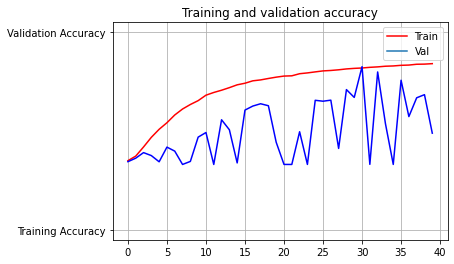

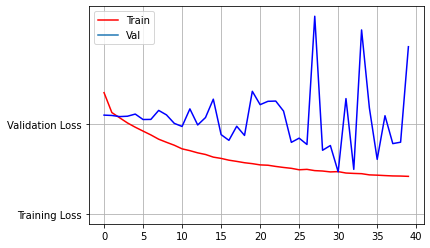

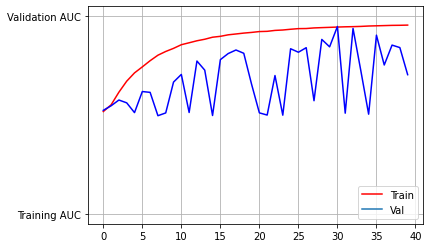

In [ ]:

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
train_auc = history.history["auc"]
val_auc  = history.history["val_auc"]

epochs=range(len(acc)) # Get number of epochs


plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(["Train", "Val"])
plt.grid()
plt.show()
print("")


plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.legend(["Train", "Val"])
plt.grid()

plt.show()
print("")
plt.plot(epochs, train_auc, 'r', "Training AUC")
plt.plot(epochs, val_auc, 'b', "Validation AUC")
plt.legend(["Train", "Val"])
plt.grid()

plt.show()

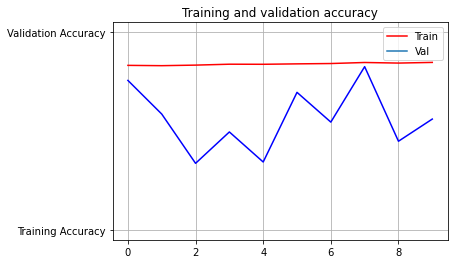

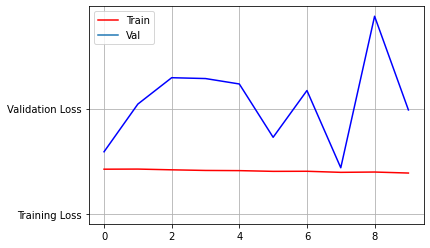

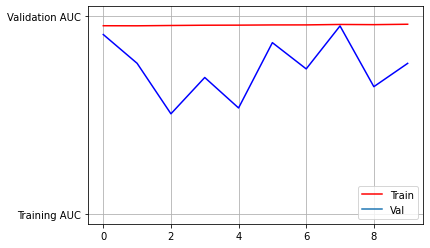

In [ ]:

acc=history_finer.history['accuracy']
val_acc=history_finer.history['val_accuracy']
loss=history_finer.history['loss']
val_loss=history_finer.history['val_loss']
train_auc = history_finer.history["auc"]
val_auc  = history_finer.history["val_auc"]

epochs=range(len(acc)) # Get number of epochs


plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(["Train", "Val"])
plt.grid()
plt.show()
print("")


plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.legend(["Train", "Val"])
plt.grid()

plt.show()
print("")
plt.plot(epochs, train_auc, 'r', "Training AUC")
plt.plot(epochs, val_auc, 'b', "Validation AUC")
plt.legend(["Train", "Val"])
plt.grid()

plt.show()

Analysis of results:
It is evident that the model is underparameterised and fully trained, this conclusion is reached as the validation and training loss are around similar and they both dont decrease by a big margin.  Training a bigger model should lead to more fruitful results.

#Bigger Model

Metrics for the bigger model for the final 30 epochs of training.

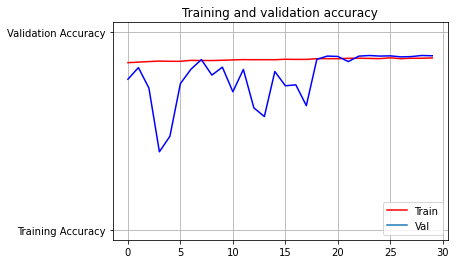

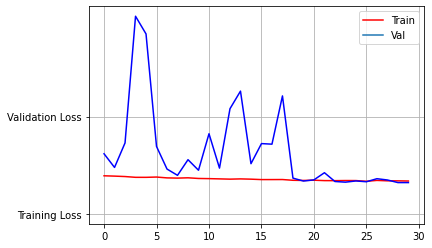

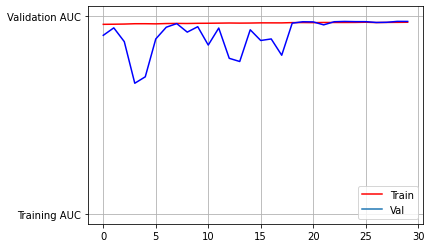

In [24]:

acc=history_bigger.history['accuracy']
val_acc=history_bigger.history['val_accuracy']
loss=history_bigger.history['loss']
val_loss=history_bigger.history['val_loss']
train_auc = history_bigger.history["auc"]
val_auc  = history_bigger.history["val_auc"]

epochs=range(len(acc)) # Get number of epochs


plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(["Train", "Val"])
plt.grid()
plt.show()
print("")


plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.legend(["Train", "Val"])
plt.grid()

plt.show()
print("")
plt.plot(epochs, train_auc, 'r', "Training AUC")
plt.plot(epochs, val_auc, 'b', "Validation AUC")
plt.legend(["Train", "Val"])
plt.grid()

plt.show()

The volitality in the metrics is attributed to the learning rate of the optimizer.  RMSprop is used which yields a more volitatile minima of the gradient[1].  Testing out the Adam optimiser lead to much slower convergence, hence RMSProp was used for the final model.
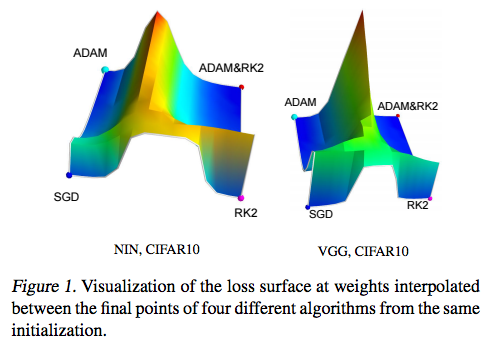
I tested the method given by this method, https://stackoverflow.com/questions/50458964/changing-optimizer-or-lr-after-loading-model-yields-strange-results
(within the solutions). In contrast to the solution proposed by the commenter, my experience with this also lead to unsavoury results so I abandoned this approach.

[1] source:https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/#:~:text=While%20momentum%20accelerates%20our%20search,of%20both%20Momentum%20and%20RMSProp.


AUC vs Accuracy?

Why I prioritised a higher AUC over a higher accuracy?

A model with a higher AUC score is more likely to perform better in future data.AUC metric cares more about the probabilities of class prediction. So a model wiht a higher AUC but the same accuracy as another model would be able to more "confidently" make classifcations.  Although accuracy does also show the general trend of the model to make better predictions.

# Future Considerations




If I had more time, the models could be extended to include a binary classifier that takes the first and second most likely classification of the images and then classifies it, this would require further models to be trained for each combination, (i.e. 3! = 6).  Further investigations could also include hyperparameter optimisation, for the last layer of the pre trained model and the number of dense layers using Hyberband.

To improve this experiment further, I highly recommend testing out other model architectures such as the higher versions of EfficentNet and ultimately ResNet.  Further studies need to be taken to understand when the model will overfit with such high parameters. This could be combatted by freezing the initial layers of the model but this could also be problematic as the datasets used to train these models is vastly diffrent to the problemset.



#Conclusion

An average AUC score of 0.974 is achieved from the validation set, compared fo 0.983 found in the model used by the researchers.  To improve the model a bigger model size is required but this is more diffcult to train computationally and is prone to overfitting due to the lack of data. I highly recommend a bigger model than the one submitted to be used, when coupled with a bigger dataset this would yield much better results (from testing done as can be seen on the notebook)